## Car Insurance Claim Prediction
*Author: Tom Cohen*

*Dataset: Sagnik1511. (2023). *Car Insurance Data* [Data set]. Kaggle. https://www.kaggle.com/datasets/sagnik1511/car-insurance-data/data*

### 1. Project introduction
All types of insurance are about managing risk. When a customer wants to buy protection from any kind of risk, insurance companies need to understand the likelihood of the risk materialising in order to correctly price their policy (as well as, in turn, manage the insurance company's own risk). In this project we'll use a dataset of customer profiles to build model that can predict whether or not a costumer with the given profile will file a claim against their insurance. This is a classic **binary classification** project ("claim" / "no claim"), and we'll do it using **supervised learning** models, which leverage the fact our data is labelled to learn the statistical patterns that differentiate customers likely to file a claim and those that aren't (more on the specific algorithms used will be discussed below). Is this a particularly innovative problem to solve? Not at all. Is it a good enough project for a final? Let's see!

##### Let's start with some basic imports for we get into the data proper

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/car-insurance-data/Car_Insurance_Claim.csv')
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


### Data overview, cleaning and EDA

In [2]:
# Start with a quick overview of shape, columns, dtypes
print(f'Shape: {df.shape}')
df.info()

# Get some statistics for numeric features
df.describe().T

Shape: (10000, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATION

,count,mean,std,min,25%,50%,75%,max
ID,10000.0,500521.906800,290030.768758,101.000000,249638.500000,501777.000000,753974.500000,999976.000000
CREDIT_SCORE,9018.0,0.515813,0.137688,0.053358,0.417191,0.525033,0.618312,0.960819
VEHICLE_OWNERSHIP,10000.0,0.697000,0.459578,0.000000,0.000000,1.000000,1.000000,1.000000
MARRIED,10000.0,0.498200,0.500022,0.000000,0.000000,0.000000,1.000000,1.000000
CHILDREN,10000.0,0.688800,0.463008,0.000000,0.000000,1.000000,1.000000,1.000000
POSTAL_CODE,10000.0,19864.548400,18915.613855,10238.000000,10238.000000,10238.000000,32765.000000,92101.000000
ANNUAL_MILEAGE,9043.0,11697.003207,2818.434528,2000.000000,10000.000000,12000.000000,14000.000000,22000.000000
SPEEDING_VIOLATIONS,10000.0,1.482900,2.241966,0.000000,0.000000,0.000000,2.000000,22.000000
DUIS,10000.0,0.239200,0.554990,0.000000,0.000000,0.000000,0.000000,6.000000
PAST_ACCIDENTS,10000.0,1.056300,1.652454,0.000000,0.000000,0.000000,2.000000,15.000000


---
**Basic data description:**
   We see the dataset contains 10,000 samples and 19 features. There are 8 categorical and 11 numeric features (right now, we'll need to convert some of them), with missing data present in the CREDIT_SCORE and ANNUAL_MILEAGE columns.
   
**Cleaning Strategy:**
1. **Missing values** – inspect and impute/drop missing datapoints appropriately.
2. **Duplicates** – remove duplicates from the data.
3. **Data types** – convert features into the right dtype.

Before we make changes, let's visualize the extent of the missing data to confirm which columns need attention. If the amount of missing data is too large imputing it might skew our results. This will help us understand the scope of our imputation.

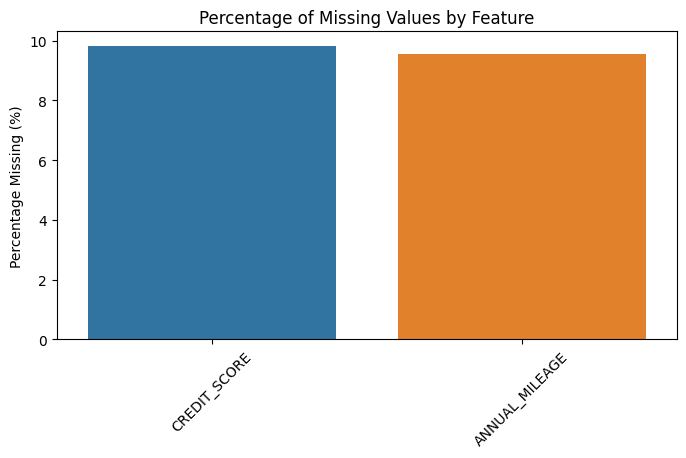

In [3]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100
missing_data = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

# Plot the missing data
plt.figure(figsize=(8, 4))
sns.barplot(x=missing_data.index, y=missing_data.values)
plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage Missing (%)')
plt.xticks(rotation=45)
plt.show()

In [4]:
# 1. Missing values
# Impute numeric points with median
for col in df.select_dtypes(include='number').columns:
    df[col].fillna(df[col].median(), inplace=True)

# Impute categorical points with mode
for col in df.select_dtypes(exclude='number').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# 2. Remove duplicates
df.drop_duplicates(inplace=True)

# 3. Convert object columns to category
for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category')

# 4. Convert numerical columns that are actually categorical appropriately
df['VEHICLE_OWNERSHIP'] = df['VEHICLE_OWNERSHIP'].astype('category')
df['MARRIED'] = df['MARRIED'].astype('category')
df['CHILDREN'] = df['CHILDREN'].astype('category')
df['POSTAL_CODE'] = df['POSTAL_CODE'].astype('category')

# 5. Drop useless columns
df.drop(columns=['ID'], inplace=True)

print(f'After cleaning: {df.shape} rows, {df.isna().sum().sum()} missing values')

After cleaning: (10000, 18) rows, 0 missing values


#### Exploratory Data Analysis

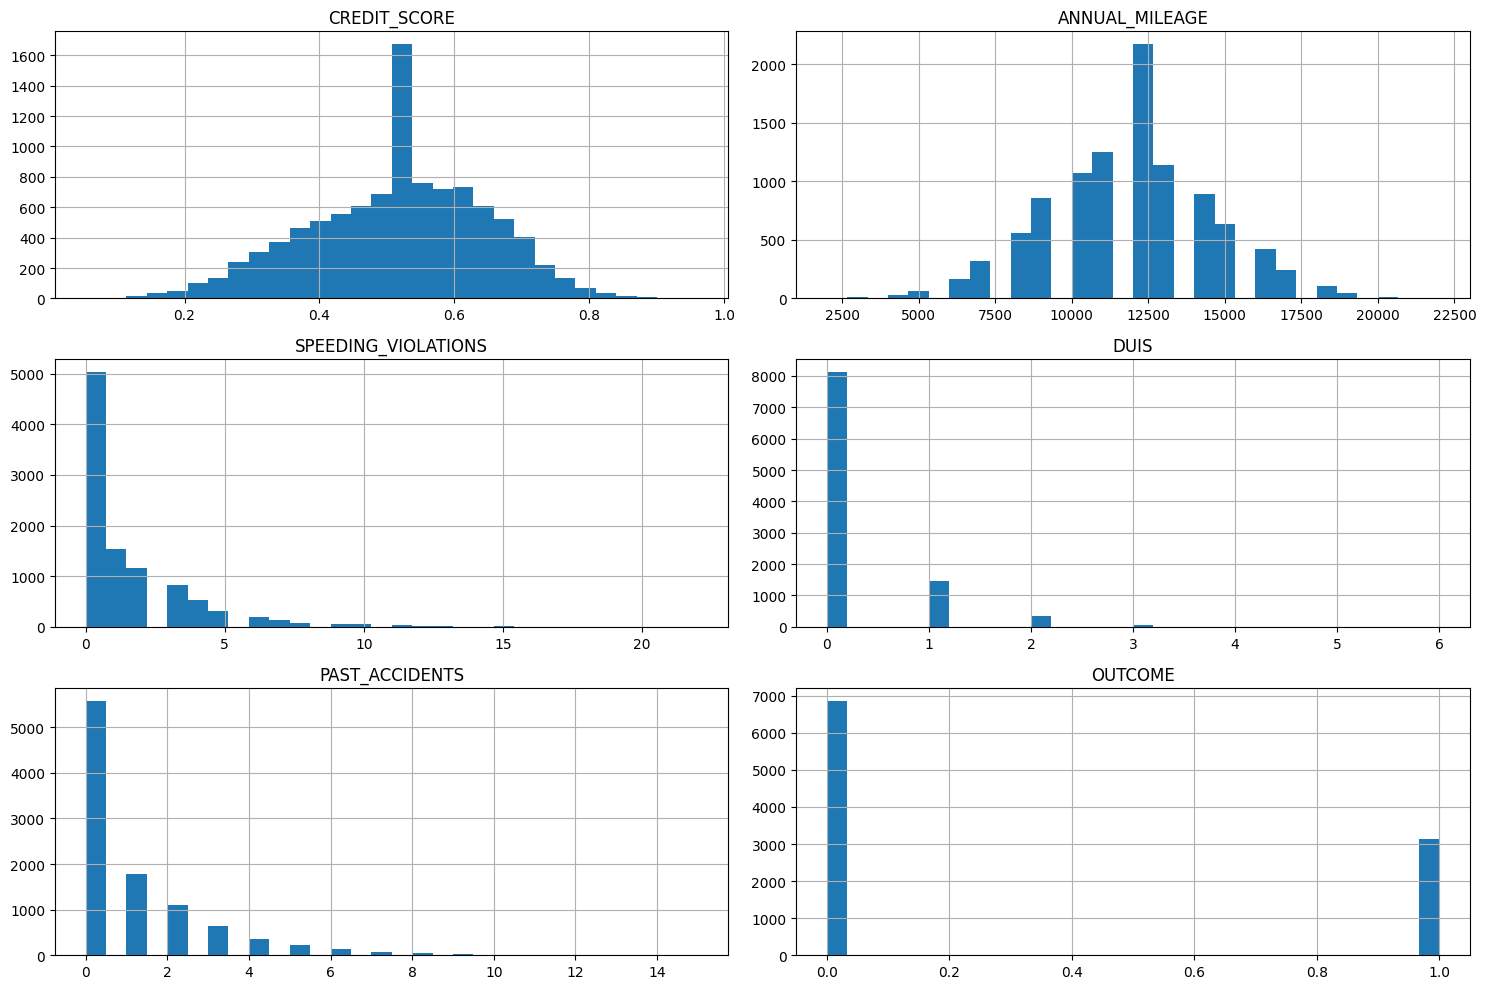

In [5]:
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

As expected, we can see spikes around the median for categories where we needed to impute data. We also see that our data is weighted about twice as much towards "No claim" outcomes - so we'll need to be careful about that when building the model.

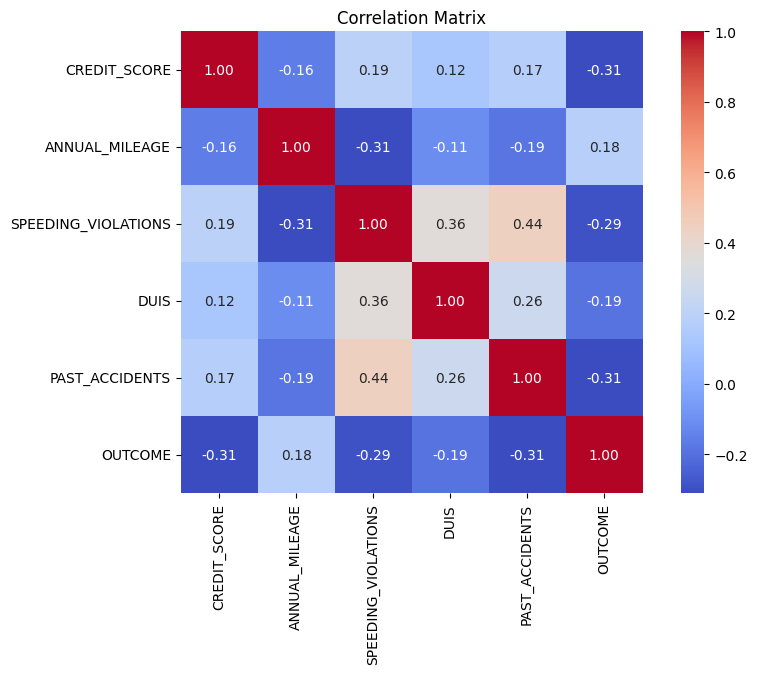

In [6]:
# Correlation heatmap
plt.figure(figsize=(10,6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

Generally our data isn't highly correlated (which is good!), apart from some correlation between speeding violations and past accidents (which is very expected). However, we can also explicitly check for multicollinearity. A VIF score above 5-10 for a feature is generally considered problematic.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Use dropna on a copy for the VIF check
X_numeric = df[numeric_cols].dropna()

# Add a constant for the VIF calculation
X_vif = sm.add_constant(X_numeric)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data[1:])

               feature       VIF
1         CREDIT_SCORE  1.130665
2       ANNUAL_MILEAGE  1.124878
3  SPEEDING_VIOLATIONS  1.470383
4                 DUIS  1.172462
5       PAST_ACCIDENTS  1.320890
6              OUTCOME  1.234250


We're good!

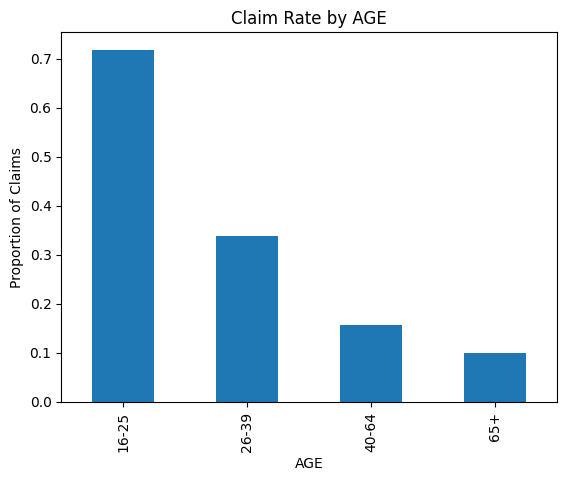

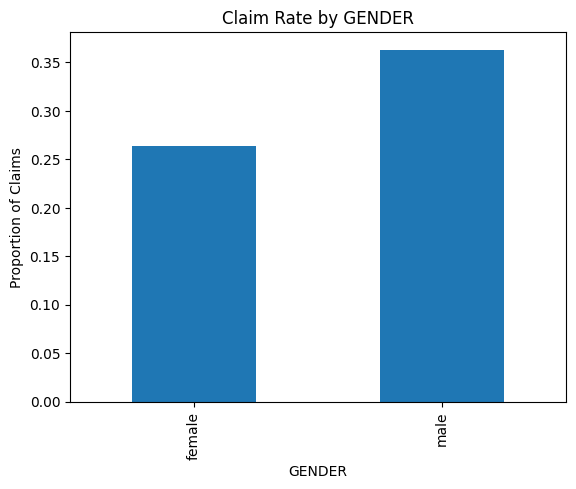

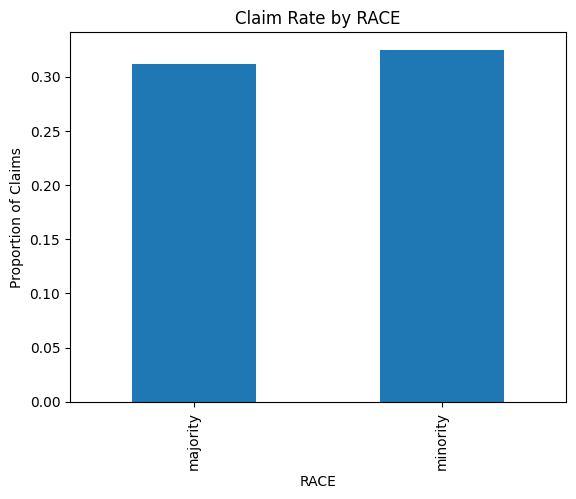

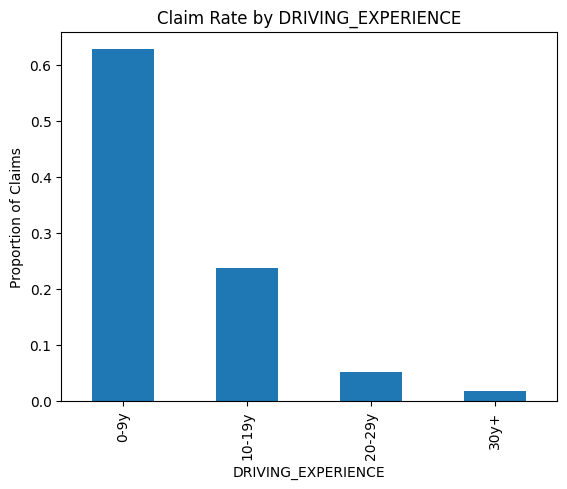

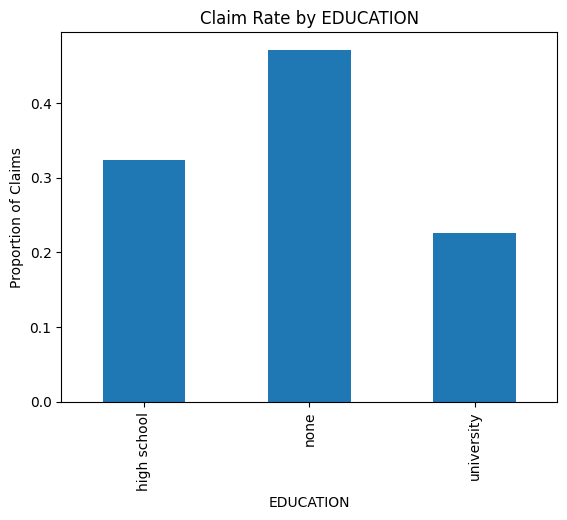

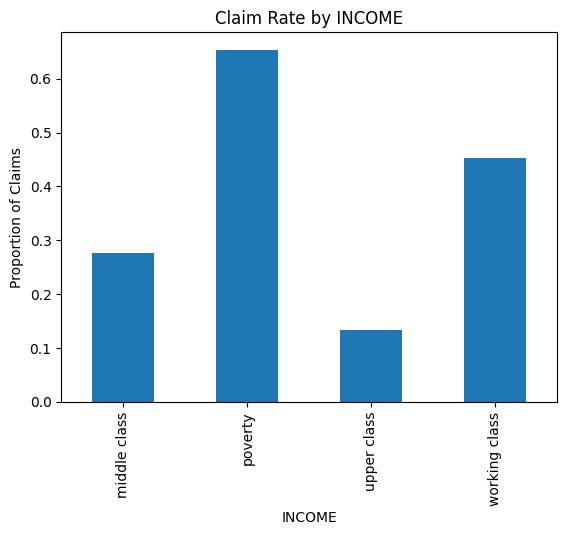

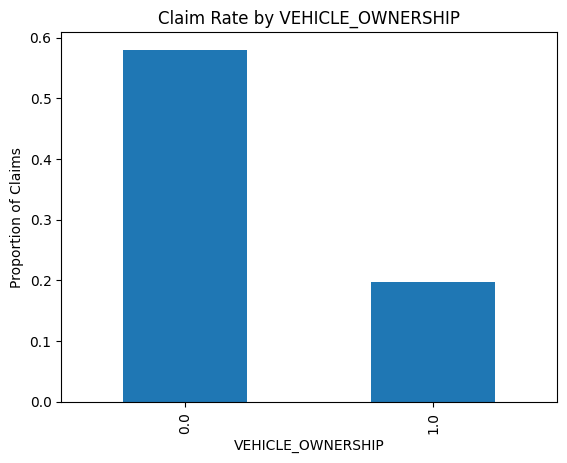

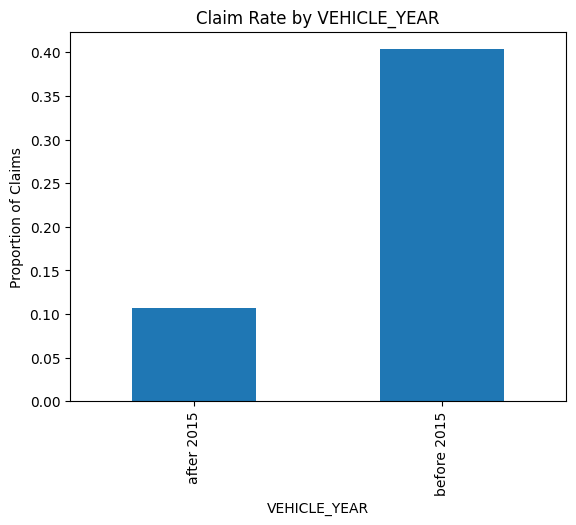

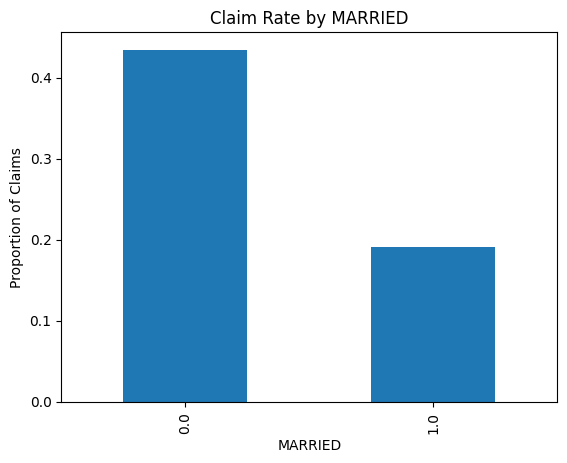

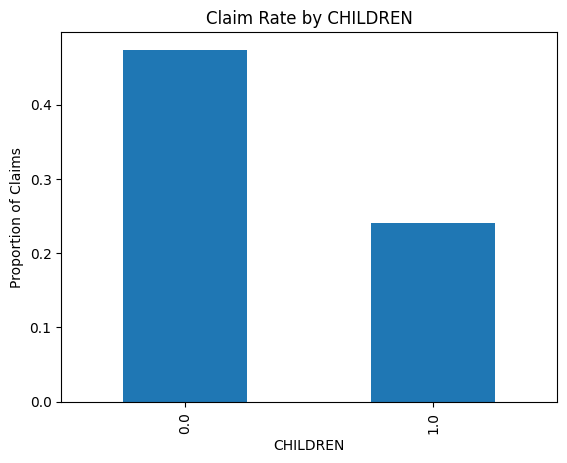

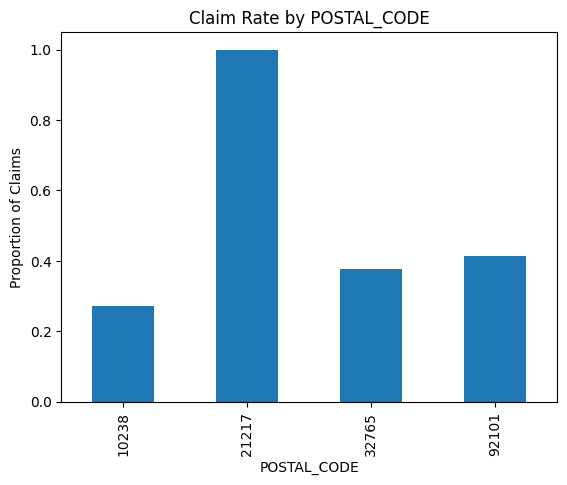

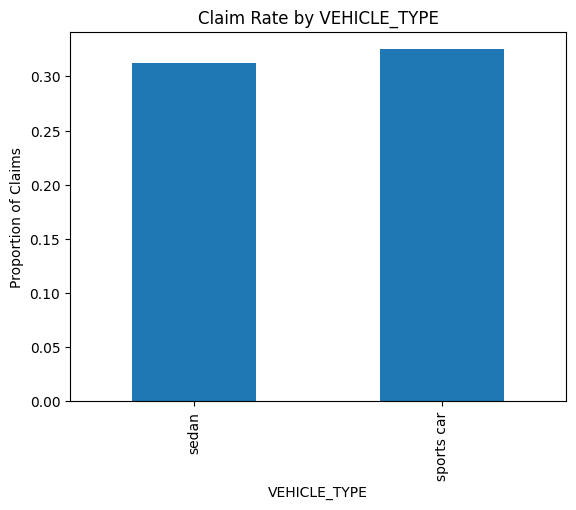

In [8]:
# Claim rate by selected categorical features
categorical_cols = df.select_dtypes(exclude='number').columns
for col in categorical_cols:
    claim_rate = df.groupby(col)['OUTCOME'].mean()
    claim_rate.plot(kind='bar')
    plt.title(f'Claim Rate by {col}')
    plt.ylabel('Proportion of Claims')
    plt.show()


## Feature Engineering & Preprocessing


In [9]:
# Separate target and features
y = df['OUTCOME']
X = df.drop(columns=['OUTCOME'])

# Identify categorical and numerical columns
cat_cols = X.select_dtypes('category').columns.tolist()
num_cols = X.select_dtypes('number').columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

## 3. Model Building & Training
In this project we'll train 3 types of models:
- Logistic Regression: It's fast, efficient, and its results are highly interpretable, which is valuable for understanding the main drivers of insurance claims. At the same time it assumes a linear relationship between the features and the outcome, so it cannot capture more complex, non-linear interactions in the data.
- Random Forest: A step up from a linear model as it can model complex, non-linear relationships. This comes at the cost of being computationally intensive: training hundreds of trees can be slower and more memory-intensive than a single logistic regression model.
- Gradient Boosting: Builds trees sequentially, where each new tree is trained to correct the errors of the previous ones. Typically the best for datasets like ours, but risks overfitting if not careful during tuning.

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
# Given we know of the imbalances in the data, can configure our training to take this into account by using class_weight='balanced'
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Define Hyperparameter Grids for Hyperparameter Tuning
param_grids = {
    'Logistic Regression': {
        'model__C': [0.1, 1.0, 10],
        'model__solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

results = {}
for name, model in models.items():
    clf_pipeline = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    grid_search = GridSearchCV(clf_pipeline, param_grid=param_grids[name], cv=5, scoring='f1', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test)
    y_proba = best_clf.predict_proba(X_test)[:, 1] if hasattr(best_clf, 'predict_proba') else None
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    }
    print(f"{name} done.")

Logistic Regression done.
Random Forest done.
Gradient Boosting done.


## Results & Analysis

When evaluating the performance of models there's no "one size fits all" metric, so we'll explore several.
* Accuracy: gives a general sense of performance, but it can be misleading in imbalanced datasets like ours (where 'No Claim' is more common).
* F1-score: provides a balanced measure of a model's performance by considering both Precision and Recall. This is why it was chosen as the primary scoring metric for our grid search.
  * Precision: of all the customers we predicted would file a claim, how many actually did? A high precision is important to avoid flagging customers incorrectly.
  * Recall: of all the customers who actually filed a claim, how many did we correctly identify? High recall is crucial to ensure the company identifies as many high-risk individuals as possible.
* ROC AUC: indicates the model's ability to distinguish between the two classes.

In [11]:
# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results).T
results_df.sort_values('ROC AUC', ascending=False)

,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression,0.8340,0.679659,0.889952,0.770718,0.915536
Gradient Boosting,0.8480,0.754331,0.763955,0.759113,0.911756
Random Forest,0.8315,0.692308,0.832536,0.755974,0.903132


<Figure size 700x700 with 0 Axes>

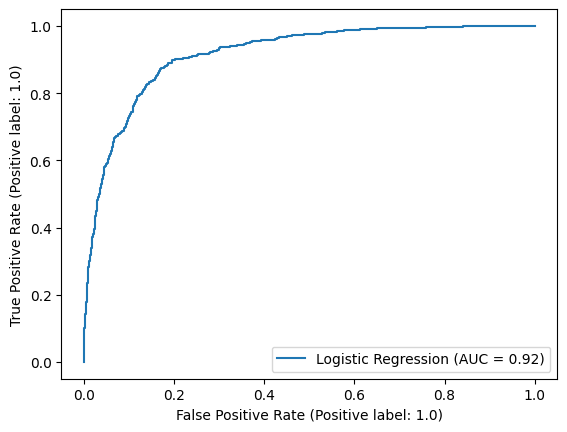

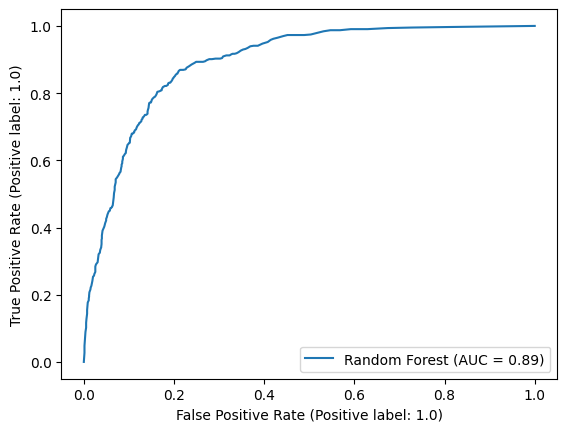

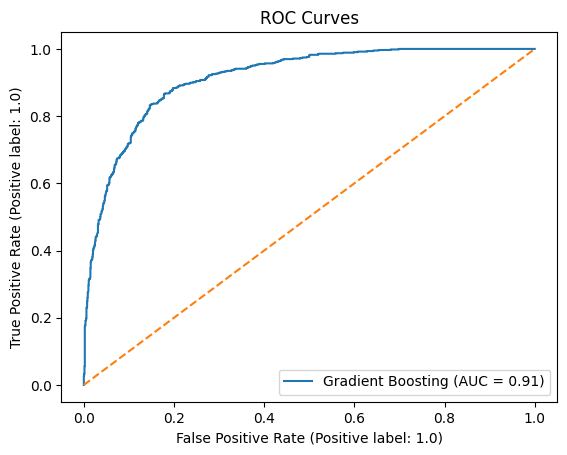

In [12]:
# Plot ROC curves
plt.figure(figsize=(7,7))
for name, model in models.items():
    clf = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    clf.fit(X_train, y_train)
    if hasattr(clf, 'predict_proba'):
        RocCurveDisplay.from_estimator(clf, X_test, y_test, name=name)
plt.plot([0,1], [0,1], linestyle='--')
plt.title('ROC Curves')
plt.show()

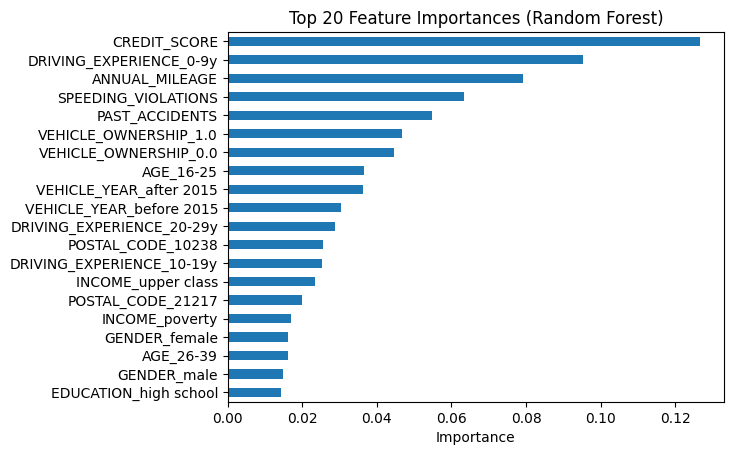

In [13]:
# Feature importance from Random Forest
rf_clf = Pipeline(steps=[('preprocess', preprocessor), ('model', models['Random Forest'])])
rf_clf.fit(X_train, y_train)

# Extract feature names after one‑hot encoding
ohe = rf_clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + encoded_cat_cols.tolist()
importances = rf_clf.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]
feat_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()

## Discussion & Conclusion
- **Best model:** Based on ROC AUC alone, the most performant model in this study is the Logistic Regression. However it also showed a sharp tradeoff between precision and recall. Our Gradient Boosting model got nearly the same result (less than 0.001 AUC difference), but was much more balanced between accuracy, precision, and recall; therefore it might serve better for real-world use.
- **Insights:** Out key predictors are interesting: the best predictor is the credit score, which is a feature where we had to impute a non-trivial amount of data (see future work below). The other two key predictors are very much expected: the more people drive the more likely they are to get into an accident (just because they are on the road more), and less experienced drivers are also more likely to get into accidents due to that lack of experience.
- **Limitations:** The dataset is relatively small and may not generalize to other markets. The models themselves are also quite simple. Further hyperparameter tuning and external validation could improve robustness.
- **Future Work:** Results might improve through experiments with advanced ensemble methods (e.g., XGBoost, LightGBM) and cost‑sensitive learning. Additional data such as driving behaviour or telematics, if available, could provide a more complete picture to more accurately profile the driver. Lastly, for this dataset specifically, it's worth looking at the impact our imputation had on the results (e.g. is the lack of credit score in the dataset correlated to a positive outcome?)

### References
1. Sagnik1511. (2023). *Car Insurance Data* [Data set]. Kaggle.
2. Géron, A. (2022). *Hands‑On Machine Learning with Scikit‑Learn, Keras, and TensorFlow* (3rd ed.). O'Reilly Media.